In [1]:
!pip install numpy>=2.0.0,<3.0.0 --quiet


/bin/bash: line 1: 3.0.0: No such file or directory


In [ ]:
#import os
#os.kill(os.getpid(), 9)


In [1]:
!pip install transformers datasets scikit-learn --quiet

import pandas as pd
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# 1. CSV yükle
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("/content/cleaned_reviews_5000 (1).csv")
df = df[["translated_text", "label"]].dropna()

# 2. Train/test ayır
X_train, X_test, y_train, y_test = train_test_split(
    df["translated_text"], df["label"], test_size=0.2, random_state=42
)

# 3. Dataset'e çevir
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

# 4. Tokenizer
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
test_dataset.set_format("torch")

# 5. Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 6. TrainingArguments — sade, hatasız
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10
)

# 7. Metric hesaplama
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# 8. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 9. Eğitim başlasın
trainer.train()

# 10. Değerlendirme
metrics = trainer.evaluate()
print(f"\n✅ Test Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"✅ F1 Score: {metrics['eval_f1']:.4f}")

# 11. Kaydet
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")
print("\n💾 Model './saved_model' klasörüne kaydedildi.")


Saving cleaned_reviews_5000 (1).csv to cleaned_reviews_5000 (1).csv


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,0.674200
20,0.720400
30,0.617200
40,0.554900
50,0.536200
60,0.356300
70,0.474100
80,0.435200
90,0.291700
100,0.267500



✅ Test Accuracy: 0.9130
✅ F1 Score: 0.9091

💾 Model './saved_model' klasörüne kaydedildi.


In [2]:
import torch

# Test verisini tokenizer'dan geçir (ham metin olarak)
X_test_texts = X_test.tolist()
y_true = y_test.tolist()

# Tokenizer ile encode et
inputs = tokenizer(X_test_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

# GPU varsa kullan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Tahmin yap
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()


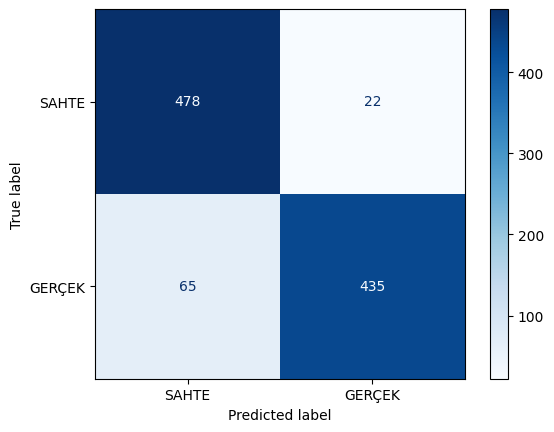

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["SAHTE", "GERÇEK"])
disp.plot(cmap="Blues", values_format="d")
